In [1]:
import os

In [2]:
import time
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
import uproot
from coffea import hist
from coffea.hist import plot
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from matplotlib.offsetbox import AnchoredText

In [3]:
pat = 'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2016/9_4_X_v04/QCD_Pt-800to1000_MuEnrichedPt5_TuneCUETP8M1_13TeV_pythia8_9_4_X_v04/'
fi = 'JetTree_mc_FatJets_Subjets_BoostedCommissioning_2.root'
f = uproot.open(pat+fi)
f

<ROOTDirectory b'JetTree_mc_FatJets_Subjets_BoostedCommissioning.root' at 0x2b6627daee10>

In [4]:
pat = 'root://xrootd-cms.infn.it///store/user/adodonov/RelValTTbar_13/pancakes-02_CMSSW_10_6_4_patch1-PU25ns_106X_upgrade2018_realistic_v9_HS_resub-v1/200131_140125/0000/RunMC2018_1.root'
f = uproot.open(pat)
f

<ROOTDirectory b'RunMC2018.root' at 0x2b6627e4b828>

In [5]:
import awkward
awkward.__version__

'0.12.20'

In [9]:
from coffea.nanoaod import NanoEvents
events =  NanoEvents.from_file('root://xrootd-cms.infn.it//store/user/lpcbacon/pancakes/02/2017/UL/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/pancakes-02_RunIISummer19UL17MiniAOD-106X_v6-v2/200127_182859/0001/nano_mc_2017_1004.root')
events

<NanoEvents [<event 0> <event 1> <event 2> ... <event 99997> <event 99998> <event 99999>] at 0x2b5279b699b0>

In [19]:
events['Electron'] = events.Electron[(events.Electron.pt > 20) & (abs(events.Electron.eta) < 2.4)]
print(len(events.Electron), len(events.Electron.counts))
print(events.Electron)
print(events.Electron.counts == 0)
#print(events.Electron.counts == 1)
print(events[events.Electron.counts == 0].Electron)
print(events[events.Electron.counts == 0].Electron.counts)

100000 100000
[[] [<Electron 0>] [] ... [] [] []]
[ True False  True ...  True  True  True]
[[] [] [] ... [] [] []]
[0 0 0 ... 0 0 0]


In [7]:
dir(events.SV)

['E',
 'Et',
 '__array_ufunc__',
 '__awkward_serialize__',
 '__class__',
 '__class__',
 '__delattr__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__dir__',
 '__doc__',
 '__doc__',
 '__eq__',
 '__eq__',
 '__format__',
 '__format__',
 '__ge__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__gt__',
 '__hash__',
 '__hash__',
 '__init__',
 '__init__',
 '__init_subclass__',
 '__init_subclass__',
 '__le__',
 '__le__',
 '__lt__',
 '__lt__',
 '__module__',
 '__ne__',
 '__ne__',
 '__new__',
 '__new__',
 '__reduce__',
 '__reduce__',
 '__reduce_ex__',
 '__reduce_ex__',
 '__repr__',
 '__repr__',
 '__self__',
 '__self_class__',
 '__setattr__',
 '__setattr__',
 '__sizeof__',
 '__sizeof__',
 '__str__',
 '__str__',
 '__subclasshook__',
 '__subclasshook__',
 '__thisclass__',
 '__weakref__',
 '_args',
 '_array',
 '_arraymethods',
 '_cache',
 '_delitem',
 '_generator',
 '_initObjectArray',
 '_keymap',
 '_kwargs',
 '_nbytes',
 '_persistentkey',
 '_persistvir

In [8]:
req_mu = (events.Muon.pt.count() >= 1)
req_ele = (events.Electron.pt.count() >= 1)
req = req_ele & req_mu

pairs = events.Muon[req_ele & req_mu].cross(events.Electron[req_ele & req_mu])
pairs = pairs[pairs.i0.charge == -1 * pairs.i1.charge]
pairs = pairs[pairs.counts == 1]
el, mu = pairs.i0[:, 0], pairs.i1[:, 0]
print(mu[:6])
print(mu[:6].charge)
print(el[:6])
print(el[:6].charge)

[<Electron 19> <Electron 47> <Electron 61> <Electron 68> <Electron 69> <Electron 77>]
[1 1 1 1 1 1]
[<Muon 7> <Muon 20> <Muon 30> <Muon 36> <Muon 37> <Muon 43>]
[-1 -1 -1 -1 -1 -1]


In [9]:
def propagate_up(subset, sel):
    dummy = np.zeros_like(subset)
    dummy[subset] = sel
    return dummy
    
a = propagate_up(req, (events[req].Muon[:, 0].charge * events[req].Electron[:, 0].charge) == -1)
print(events[a].Muon[:, 0][:6])
print(events[a].Muon[:, 0].charge[:6])
print(events[a].Electron[:, 0][:6])
print(events[a].Electron[:, 0].charge[:6])

[<Muon 1> <Muon 2> <Muon 7> <Muon 18> <Muon 20> <Muon 30>]
[ 1 -1 -1  1 -1 -1]
[<Electron 7> <Electron 9> <Electron 19> <Electron 38> <Electron 47> <Electron 61>]
[-1  1  1 -1  1  1]


In [10]:
for i in range(0,100):
    #print(events[i].Muon, events[i].Electron, events[i].Muon.charge,  events[i].Electron.charge)
    if (events[i].Muon.size >= 1) & (events[i].Electron.size >= 1):
        if events[i].Muon[0].charge == -1 * events[i].Electron[0].charge:
            print("Event", i, events[i].Muon.charge, events[i].Electron.charge, events[i].Muon, events[i].Electron)
        #print("Event", i, events[i].Muon.charge, events[i].Electron.charge, events[i].Muon, events[i].Electron)

Event 7 [1] [-1 -1] [<Muon 1>] [<Electron 7> <Electron 8>]
Event 8 [-1 -1] [ 1  1 -1 -1 -1] [<Muon 2> <Muon 3>] [<Electron 9> <Electron 10> <Electron 11> <Electron 12> <Electron 13>]
Event 15 [-1  1] [1] [<Muon 7> <Muon 8>] [<Electron 19>]
Event 28 [1] [-1  1 -1  1] [<Muon 18>] [<Electron 38> <Electron 39> <Electron 40> <Electron 41>]
Event 33 [-1] [ 1 -1 -1] [<Muon 20>] [<Electron 47> <Electron 48> <Electron 49>]
Event 45 [-1  1  1] [1] [<Muon 30> <Muon 31> <Muon 32>] [<Electron 61>]
Event 53 [-1] [1] [<Muon 37>] [<Electron 69>]
Event 55 [1] [-1 -1] [<Muon 42>] [<Electron 74> <Electron 75>]
Event 57 [1] [-1] [<Muon 44>] [<Electron 78>]
Event 58 [-1] [ 1 -1] [<Muon 45>] [<Electron 79> <Electron 80>]
Event 66 [1] [-1 -1] [<Muon 55>] [<Electron 88> <Electron 89>]
Event 68 [1] [-1  1] [<Muon 56>] [<Electron 91> <Electron 92>]
Event 72 [1] [-1 -1] [<Muon 61>] [<Electron 93> <Electron 94>]
Event 75 [ 1 -1] [-1] [<Muon 63> <Muon 64>] [<Electron 98>]
Event 88 [1] [-1] [<Muon 70>] [<Electron 1

In [11]:
print(events.Muon.counts.sum())
events.Muon = events.Muon[(events.Muon.pt > 20) & (events.Muon.eta < 2.4)]
print(events.Muon.counts.sum())
dir(events.Muon)

89252
35438


['E',
 'Et',
 '__array_ufunc__',
 '__awkward_serialize__',
 '__class__',
 '__class__',
 '__delattr__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__dir__',
 '__doc__',
 '__doc__',
 '__eq__',
 '__eq__',
 '__format__',
 '__format__',
 '__ge__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__gt__',
 '__hash__',
 '__hash__',
 '__init__',
 '__init__',
 '__init_subclass__',
 '__init_subclass__',
 '__le__',
 '__le__',
 '__lt__',
 '__lt__',
 '__module__',
 '__ne__',
 '__ne__',
 '__new__',
 '__new__',
 '__reduce__',
 '__reduce__',
 '__reduce_ex__',
 '__reduce_ex__',
 '__repr__',
 '__repr__',
 '__self__',
 '__self_class__',
 '__setattr__',
 '__setattr__',
 '__sizeof__',
 '__sizeof__',
 '__str__',
 '__str__',
 '__subclasshook__',
 '__subclasshook__',
 '__thisclass__',
 '__weakref__',
 '_arraymethods',
 '_content',
 '_counts',
 '_finalize',
 '_initObjectArray',
 '_isvalid',
 '_keymap',
 '_offsets',
 '_parents',
 '_rotate_axis',
 '_rotate_euler',
 '_

In [12]:
print(events.Electron.counts.sum())
events.Electron = events.Electron[(events.Electron.pt > 20) & (events.Electron.eta < 2.4)]
print(events.Electron.counts.sum())
dir(events.Electron)

114533
48655


['E',
 'Et',
 'FAIL',
 'LOOSE',
 'MEDIUM',
 'TIGHT',
 'VETO',
 '__array_ufunc__',
 '__awkward_serialize__',
 '__class__',
 '__class__',
 '__delattr__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__dir__',
 '__doc__',
 '__doc__',
 '__eq__',
 '__eq__',
 '__format__',
 '__format__',
 '__ge__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__gt__',
 '__hash__',
 '__hash__',
 '__init__',
 '__init__',
 '__init_subclass__',
 '__init_subclass__',
 '__le__',
 '__le__',
 '__lt__',
 '__lt__',
 '__module__',
 '__ne__',
 '__ne__',
 '__new__',
 '__new__',
 '__reduce__',
 '__reduce__',
 '__reduce_ex__',
 '__reduce_ex__',
 '__repr__',
 '__repr__',
 '__self__',
 '__self_class__',
 '__setattr__',
 '__setattr__',
 '__sizeof__',
 '__sizeof__',
 '__str__',
 '__str__',
 '__subclasshook__',
 '__subclasshook__',
 '__thisclass__',
 '__weakref__',
 '_arraymethods',
 '_content',
 '_counts',
 '_finalize',
 '_initObjectArray',
 '_isvalid',
 '_keymap',
 '_offsets',
 '

In [41]:
print(len(events.Electron), len(events.Electron.counts))
print(events.Electron)
print(events.Electron.counts == 0)
#print(events.Electron.counts == 1)
print(events[events.Electron.counts == 0].Electron)

100000 100000
[[] [<Electron 0>] [] ... [] [] []]
[ True False  True ...  True  True  True]
[[] [] [] ... [<Electron 114531>] [<Electron 114532>] []]


In [13]:
xrd = 'root://xrootd-cms.infn.it//'
pdict = {
    '/store/user/adodonov/EGamma/pancakes-02_Run2018A-ForValUL2018-v2/200129_212244/0000/':[
        'Run2018A_{}.root'.format(i) for i in range(1, 39)],
    '/store/user/adodonov/EGamma/pancakes-02_Run2018B-ForValUL2018-v2/200129_210753/0000/':[
        'Run2018B_{}.root'.format(i) for i in range(1, 151)],
    '/store/user/adodonov/EGamma/pancakes-02_Run2018C-ForValUL2018-v2/200129_212537/0000/':[
        'Run2018C_{}.root'.format(i) for i in range(1, 25)],
    '/store/user/adodonov/EGamma/pancakes-02_Run2018D-ForValUL2018-v2/200129_212949/0000/':[
        'Run2018D_{}.root'.format(i) for i in range(1, 89)],
    
}

fdict = {}
for k in pdict.keys():
    fdict['Run2018'+k.split('Run2018')[-1][0]] = [xrd+k+f for f in pdict[k]]
datadict = {'Data': []}
for k in fdict.keys():
    datadict['Data'] = datadict['Data'] + fdict[k]

In [14]:
class NanoEventsProcessor(processor.ProcessorABC):
    def __init__(self, columns=[]):
        self._columns = columns
        
        # Define axes
        # Should read axes from NanoAOD config
        dataset_axis = hist.Cat("dataset", "Primary dataset")

        # Events
        nel_axis   = hist.Bin("nel",   r"N electrons", [0,1,2,3,4,5,6,7,8,9,10])
        nmu_axis   = hist.Bin("nmu",   r"N muons",     [0,1,2,3,4,5,6,7,8,9,10])
        njet_axis  = hist.Bin("njet",  r"N jets",      [0,1,2,3,4,5,6,7,8,9,10])
        nbjet_axis = hist.Bin("nbjet", r"N b-jets",    [0,1,2,3,4,5,6,7,8,9,10])

        # Electron
        el_pt_axis   = hist.Bin("pt",    r"Electron $p_{T}$ [GeV]", 100, 20, 400)
        el_eta_axis  = hist.Bin("eta",   r"$\eta$", 60, -3, 3)
        el_phi_axis  = hist.Bin("phi",   r"$\phi$", 60, -3, 3)
        lelpt_axis   = hist.Bin("lelpt", r"Leading electron $p_{T}$ [GeV]", 100, 20, 200)
        
        # Muons
        mu_pt_axis   = hist.Bin("pt",    r"Muon $p_{T}$ [GeV]", 100, 20, 400)
        mu_eta_axis  = hist.Bin("eta",   r"$\eta$", 60, -3, 3)
        mu_phi_axis  = hist.Bin("phi",   r"$\phi$", 60, -3, 3)
        lmupt_axis   = hist.Bin("lmupt", r"Leading muon $p_{T}$ [GeV]", 100, 20, 200)
        
        # Jet
        jet_pt_axis   = hist.Bin("pt",   r"Jet $p_{T}$ [GeV]", 100, 20, 400)
        jet_eta_axis  = hist.Bin("eta",  r"$\eta$", 60, -3, 3)
        jet_phi_axis  = hist.Bin("phi",  r"$\phi$", 60, -3, 3)
        jet_mass_axis = hist.Bin("mass", r"Jet $m$ [GeV]", 100, 0, 50)
        ljpt_axis     = hist.Bin("ljpt", r"Leading jet $p_{T}$ [GeV]", 100, 20, 400)
                
        # Define similar axes dynamically
        disc_list = ["btagCMVA", "btagCSVV2", 'btagDeepB', 'btagDeepC', 'btagDeepFlavB', 'btagDeepFlavC',]
        btag_axes = []
        for d in disc_list:
            btag_axes.append(hist.Bin(d, d, 50, 0, 1))        

        # Define histograms from axes
        _hist_jet_dict = {
                'pt'  : hist.Hist("Counts", dataset_axis, jet_pt_axis),
                'eta' : hist.Hist("Counts", dataset_axis, jet_eta_axis),
                'phi' : hist.Hist("Counts", dataset_axis, jet_phi_axis),
                'mass': hist.Hist("Counts", dataset_axis, jet_mass_axis),
            }
        
        # Generate some histograms dynamically
        for disc, axis in zip(disc_list, btag_axes):
            _hist_jet_dict[disc] = hist.Hist("Counts", dataset_axis, axis)
        
        _hist_event_dict = {
                'njet'  : hist.Hist("Counts", dataset_axis, njet_axis),
                'nbjet' : hist.Hist("Counts", dataset_axis, nbjet_axis),
                'nel'   : hist.Hist("Counts", dataset_axis, nel_axis),
                'nmu'   : hist.Hist("Counts", dataset_axis, nmu_axis),
                'lelpt' : hist.Hist("Counts", dataset_axis, lelpt_axis),
                'lmupt' : hist.Hist("Counts", dataset_axis, lmupt_axis),
                'ljpt'  : hist.Hist("Counts", dataset_axis, ljpt_axis),
            }
        
        self.jet_hists = list(_hist_jet_dict.keys())
        self.event_hists = list(_hist_event_dict.keys())
    
        _hist_dict = {**_hist_jet_dict, **_hist_event_dict}
        _hist_dict['cutflow_ttbar'] = processor.defaultdict_accumulator(float)
        _hist_dict['cutflow_Data'] = processor.defaultdict_accumulator(float)
        self._accumulator = processor.dict_accumulator(_hist_dict)

    @property
    def columns(self):
        return self._columns

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata['dataset']
        
        ##############
        # Trigger level
        triggers = [
        #"HLT_Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ",
        "HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ",
        #"HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ",  
        ]
        
        trig_arrs = [events.HLT[_trig.strip("HLT_")] for _trig in triggers]
        req_trig = np.logical_or.reduce(np.vstack(trig_arrs), axis=0)

        ############
        # Event level
        
        ## Muon cuts
        
        # muon twiki: https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideMuonIdRun2
        events.Muon = events.Muon[(events.Muon.pt > 30) & (abs(events.Muon.eta < 2.4))] # & (events.Muon.tightId > .5)
        req_muon =(events.Muon.counts == 1)
        
        ## Electron cuts
        
        # electron twiki: https://twiki.cern.ch/twiki/bin/viewauth/CMS/CutBasedElectronIdentificationRun2
        events.Electron = events.Electron[(events.Electron.pt > 30) & (abs(events.Electron.eta) < 2.4)]
        req_ele = (events.Electron.counts == 1)
        
        events.Jet = events.Jet[(events.Jet.pt > 25) & (abs(events.Jet.eta) <= 2.5)]
        req_jets = (events.Jet.counts >= 2)    
        
        req_opposite_charge = propagate_up(req_ele & req_muon,
                                           (events[req_ele & req_muon].Muon[:, 0].charge * events[req_ele & req_muon].Electron[:, 0].charge) == -1)
        
        event_level = req_trig & req_muon & req_ele & req_opposite_charge & req_jets
        
        # Cutflow
        if dataset == 'ttbar':
            output['cutflow_ttbar']['all events'] += events.Jet.size
            output['cutflow_ttbar']['trigger'] += events[req_trig].Jet.size
            output['cutflow_ttbar']['1e1mu2j'] += events[req_trig & event_level].Jet.size
        elif dataset == 'Data':
            output['cutflow_Data']['all events'] += events.Jet.size
            output['cutflow_Data']['trigger'] += events[req_trig].Jet.size
            output['cutflow_Data']['1e1mu2j'] += events[req_trig & event_level].Jet.size
        
        # Selected
        selev = events[event_level]    
        
        #########
        
        # Per electron
        el_eta   = (abs(selev.Electron.eta) <= 2.4)
        el_pt    = selev.Electron.pt > 30
        el_level = el_eta & el_pt
        
        # Per muon
        mu_eta   = (abs(selev.Muon.eta) <= 2.4)
        mu_pt    = selev.Muon.pt > 30
        mu_level = mu_eta & mu_pt
        
        # Per jet
        jet_eta    = (abs(selev.Jet.eta) <= 2.4)
        jet_pt     = selev.Jet.pt > 25
        jet_pu     = selev.Jet.puId > 6
        jet_level  = jet_pu & jet_eta & jet_pt
        
        # b-tag twiki : https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X
        bjet_disc  = selev.Jet.btagDeepB > 0.7264 # L=0.0494, M=0.2770, T=0.7264
        bjet_level = jet_level & bjet_disc
        
        # Cutflow
        if dataset == 'ttbar':
            output['cutflow_ttbar']['PU cut'] += selev.Jet[jet_pu].size
            output['cutflow_ttbar']['pT cut'] += selev.Jet[jet_pu & jet_pt].size
            output['cutflow_ttbar']['eta cut'] += selev.Jet[jet_level].size
        elif dataset == 'Data':
            output['cutflow_Data']['PU cut'] += selev.Jet[jet_pu].size
            output['cutflow_Data']['pT cut'] += selev.Jet[jet_pu & jet_pt].size
            output['cutflow_Data']['eta cut'] += selev.Jet[jet_level].size

        sel    = selev.Electron[el_level]
        smu    = selev.Muon[mu_level]
        sjets  = selev.Jet[jet_level]
        sbjets = selev.Jet[bjet_level]
        
        # output['pt'].fill(dataset=dataset, pt=selev.Jet.pt.flatten())
        # Fill histograms dynamically  
        for histname, h in output.items():
            if histname not in self.jet_hists: continue
            # Get valid fields perhistogram to fill
            fields = {k: sjets[k].flatten() for k in h.fields if k in dir(sjets)}
            h.fill(dataset=dataset, **fields)
#         for histname, h in output.items():
#             if histname not in self.event_hists: continue
#             # Get valid fields perhistogram to fill
#             fields = {k: selev[k].flatten() for k in h.fields if k in dir(selev)}
#             h.fill(dataset=dataset, **fields)

        output['njet'].fill(dataset=dataset,  njet=sjets.counts)
        output['nbjet'].fill(dataset=dataset, nbjet=sbjets.counts)
        output['nel'].fill(dataset=dataset,   nel=sel.counts)
        output['nmu'].fill(dataset=dataset,   nmu=smu.counts)

        output['lelpt'].fill(dataset=dataset, lelpt=selev.Electron[:, 0].pt.flatten())
        output['lmupt'].fill(dataset=dataset, lmupt=selev.Muon[:, 0].pt.flatten())
        output['ljpt'].fill(dataset=dataset,  ljpt=selev.Jet[:, 0].pt.flatten())

        return output

    def postprocess(self, accumulator):
        return accumulator

In [15]:
# from pyinstrument import Profiler
# tstart = time.time()    

# profiler = Profiler()
# profiler.start()

fileset = {
    'ttbar': [
        'root://xrootd-cms.infn.it//store/user/adodonov/RelValTTbar_13/pancakes-02_CMSSW_10_6_4_patch1-PU25ns_106X_upgrade2018_realistic_v9_HS_resub-v1/200131_140125/0000/RunMC2018_1.root'
    ],
    'Data': datadict['Data'][:25] # was 10: changed number of files to run on to 25
}

output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=NanoEventsProcessor(),
                                  #executor=processor.iterative_executor,
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'nano': True,
                                                 'xrootdtimeout':30,
                                                 'skipbadfiles':True,
                                                },
                                 )

# profiler.stop()

# print(profiler.output_text(unicode=True, color=True))

# elapsed = time.time() - tstart
#output

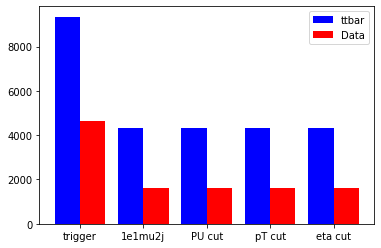

In [16]:
xlabels = list(output['cutflow_ttbar'].keys())[1:]
y = list(output['cutflow_ttbar'].values())[1:]
y2 = list(output['cutflow_Data'].values())[1:]
#y = y/np.sum(y)
#y2 = y2/np.sum(y2)
x = np.arange(len(y))
plt.bar(x-0.2, y, width=0.4, color='b', align='center', label='ttbar')
plt.bar(x+0.2, y2, width=0.4, color='r', align='center', label='Data')
#plt.semilogy()
plt.gca().set_xticks(x);
plt.gca().set_xticklabels(xlabels);
plt.legend()
plt.show()

In [24]:
output['nmu'].values()

{('Data',): array([   0., 1620.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 ('ttbar',): array([4.000e+00, 4.326e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])}

btagCMVA btagCSVV2


/beegfs/desy/user/anovak/miniconda3/envs/coffea/lib/python3.7/site-packages/mplhep/plot.py:343: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


btagDeepB btagDeepC
btagDeepFlavB btagDeepFlavC
njet nbjet
nel nmu
lelpt lmupt


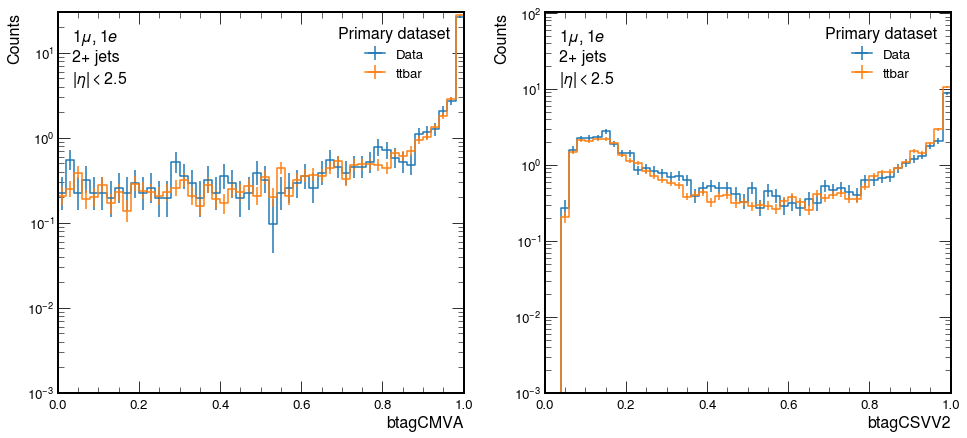

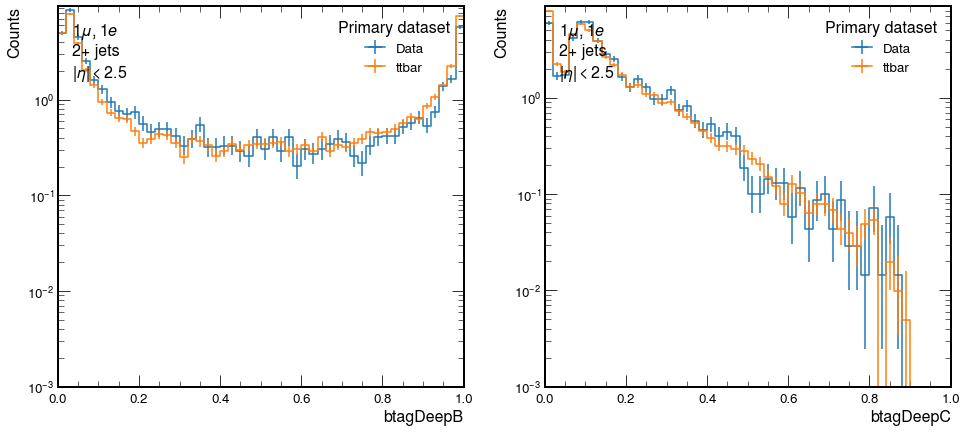

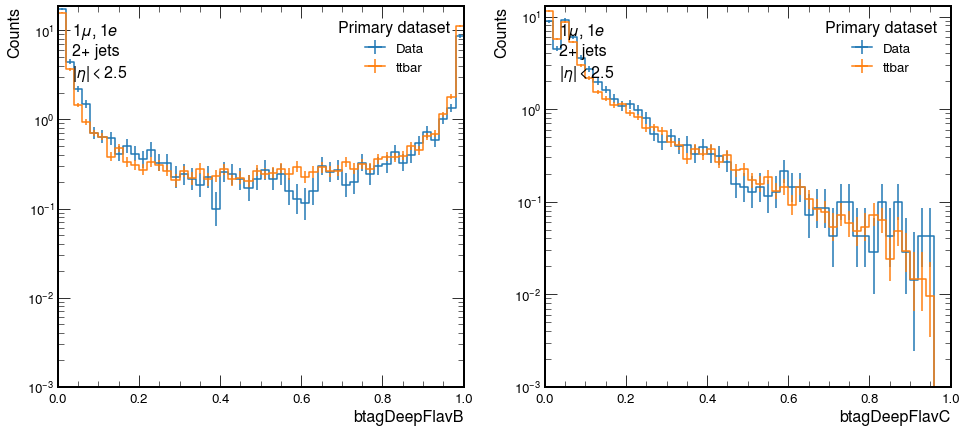

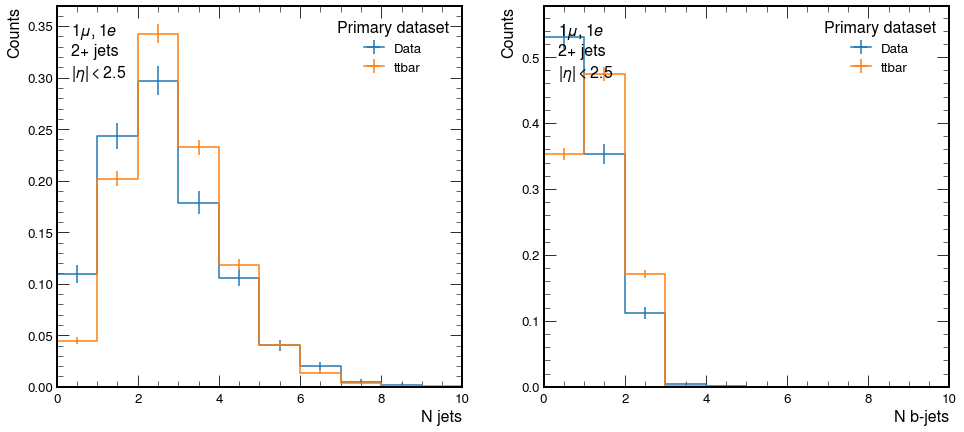

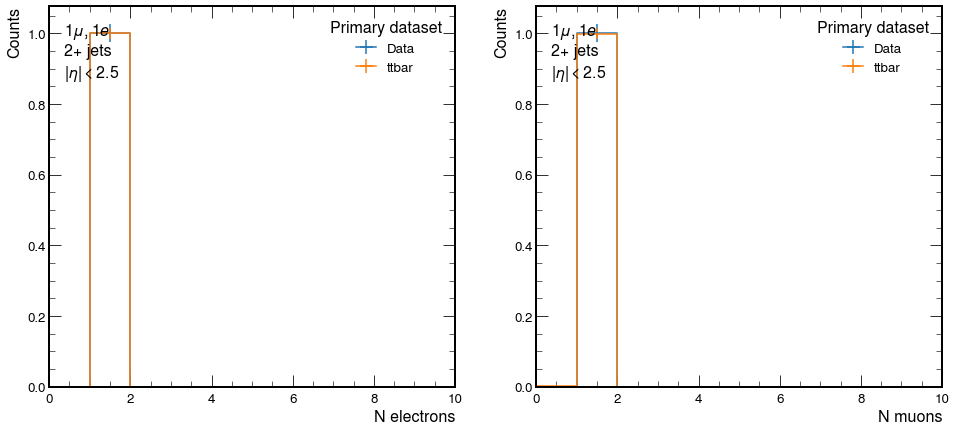

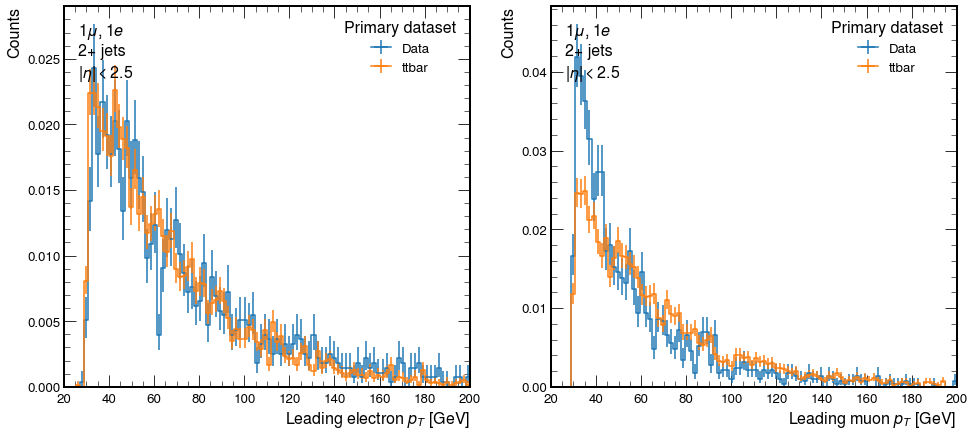

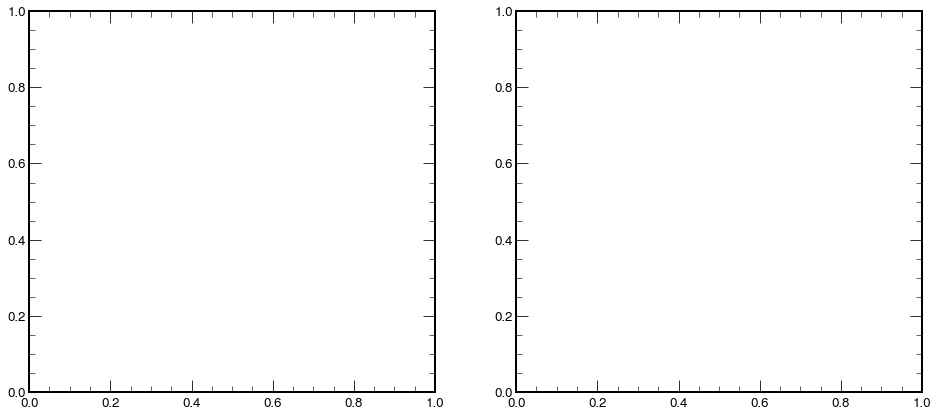

In [17]:
plt.style.use([hep.style.ROOT, {'font.size': 16}])

for i in range(0, int(round(len(output.keys())))-1, 2)[2:]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    h1name = list(output.keys())[i]
    h2name = list(output.keys())[i+1]
    if any([h1name.startswith('cutflow'), h2name.startswith('cutflow')]): break
    print(h1name, h2name)
    h1 = output[h1name]
    h2 = output[h2name]
    dense = True
    
    for ax, h in zip([ax1, ax2], [h1, h2]):
        if hasattr(h, 'dim'):
            plot.plot1d(h, ax=ax, legend_opts={'loc':1}, density=dense);
        else:
            continue    
    for ax, hname in zip([ax1, ax2], [h1name, h2name]):
        at = AnchoredText(r"$1\mu, 1e$"+"\n"+
                           "2+ jets"+"\n"+
                          r"$|\eta| < 2.5$",
                           loc=2, frameon=False)
        ax.add_artist(at)
        if hname.startswith("btag"):
            ax.semilogy()
        ax.set_ylim(0.001, None)
    hep.mpl_magic(ax1)
    hep.mpl_magic(ax2)
    #break

In [18]:
hep.__version__

AttributeError: module 'mplhep' has no attribute '__version__'